In [1]:
# If not already installed, do: pip install pandas fastparquet
import pandas as pd

URL_DATA = 'https://storage.data.gov.my/transportation/ktmb/ets_2025.parquet'

df = pd.read_parquet(URL_DATA)
if 'date' in df.columns: df['date'] = pd.to_datetime(df['date'])

print(df)

             date   time         origin    destination  ridership
0      2025-01-01  00:00     Batu Gajah     Alor Setar          1
1      2025-01-01  00:00     Batu Gajah           Arau          1
2      2025-01-01  00:00     Batu Gajah   Padang Besar          1
3      2025-01-01  00:00         Kampar   Padang Besar          2
4      2025-01-01  00:00  Tanjong Malim     Alor Setar          1
...           ...    ...            ...            ...        ...
181256 2025-05-16  23:00   Sungai Buloh        Taiping          2
181257 2025-05-16  23:00   Sungai Buloh  Tasek Gelugor          3
181258 2025-05-16  23:00  Tanjong Malim           Ipoh          3
181259 2025-05-16  23:00     Tapah Road     Batu Gajah          1
181260 2025-05-16  23:00     Tapah Road           Ipoh          1

[181261 rows x 5 columns]


In [2]:
df_daily = df.groupby('date')['ridership'].sum().reset_index()

In [3]:
df_daily.set_index('date',inplace=True)

In [4]:
print(df_daily)

            ridership
date                 
2025-01-01      11434
2025-01-02      11010
2025-01-03      11331
2025-01-04      11286
2025-01-05      11804
...               ...
2025-05-12      12407
2025-05-13      10920
2025-05-14         30
2025-05-15       9408
2025-05-16      11292

[136 rows x 1 columns]


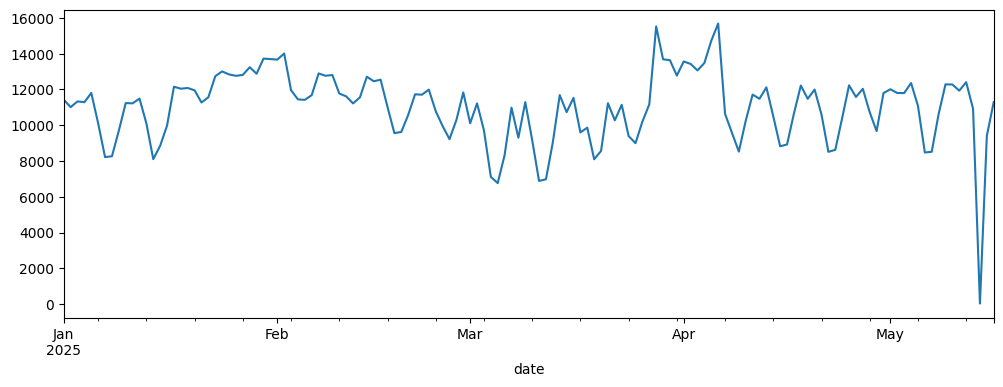

In [5]:
import matplotlib.pyplot as plt

df_daily['ridership'].plot(figsize=(12,4))
plt.show()

In [6]:
import holidays

my_holidays = holidays.MY(years=[2023,2024,2025])
df_daily['is_holiday'] = df_daily.index.to_series().apply(lambda x:x in my_holidays)

In [7]:
df_daily[df_daily['is_holiday']==True]

,ridership,is_holiday
date,,
2025-01-29,12880,True
2025-01-30,13724,True
2025-03-31,12774,True
2025-04-01,13564,True
2025-05-01,12010,True
2025-05-12,12407,True


In [8]:
df_daily['dayofweek'] = df_daily.index.dayofweek # 0 = Monday, 6 = Sunday

ADF

In [9]:
# check for linearity
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_daily['ridership'])
print("Augmented Dickey-Fuller (ADF): ", result[0])
print("p-value: ", result[1])

# The ADF test helps determine if a time series is stationary or non-stationary. Stationarity is a key assumption for many time series models and forecasting techniques.
# If a time series is non-stationary, its statistical properties (like mean and variance) change over time, making it unsuitable for certain models. 

Augmented Dickey-Fuller (ADF):  -3.0532025705424473
p-value:  0.030215887838464645


| Term                            | Meaning                                                                                    |
| ------------------------------- | ------------------------------------------------------------------------------------------ |
| **ADF Statistic**               | The test statistic. The more negative, the stronger the evidence against non-stationarity. |
| **p-value**                     | If **< 0.05**, we reject the null hypothesis. That means the data is **stationary**.       |
| **Null Hypothesis (H₀)**        | The series **has a unit root** → i.e., it is **non-stationary**.                           |
| **Alternative Hypothesis (H₁)** | The series is **stationary**.                                                              |


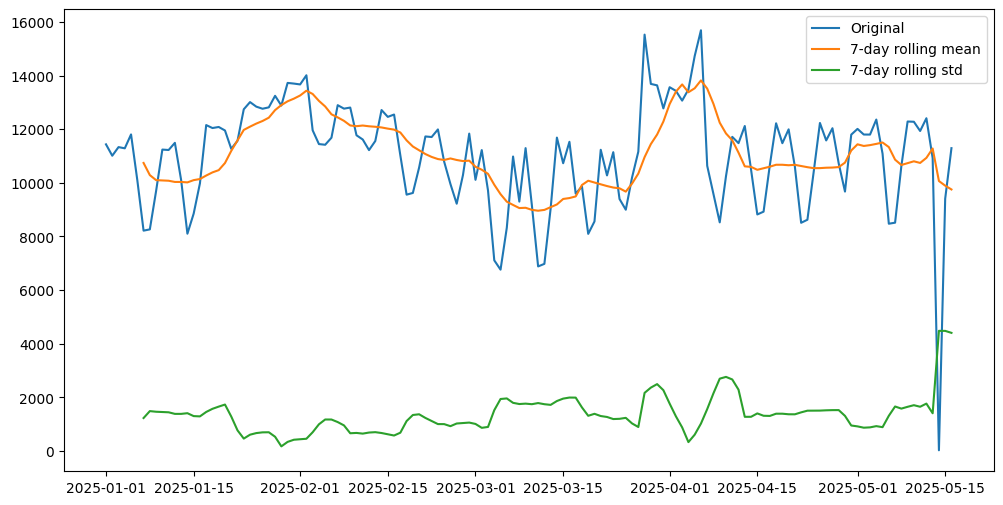

In [10]:
#plot moving average

df_daily['rolling_mean'] = df_daily['ridership'].rolling(window=7).mean()
df_daily['rolling_std'] = df_daily['ridership'].rolling(window=7).std()

plt.figure(figsize=(12,6))
plt.plot(df_daily['ridership'],label='Original')
plt.plot(df_daily['rolling_mean'], label='7-day rolling mean')
plt.plot(df_daily['rolling_std'],label='7-day rolling std')
plt.legend()
plt.show()

Original Line (Blue or solid)
→ This is the actual ridership on Jan 15.
For example: if the y-axis shows 6,000, then 6,000 people used the system that day.

Rolling Mean Line (e.g., orange or dashed)
→ This shows the average ridership over the previous 7 days leading up to Jan 15 (i.e., Jan 9 to Jan 15).
If the orange line is at 5,800, it means on average, about 5,800 people used the LRT each day in the last week.

Rolling Std Dev Line (e.g., green or dotted)
→ This line tells you how much variation there was in daily ridership in that same 7-day window.
If it’s low, ridership was steady. If it’s high, ridership was bouncing up and down.

Summary
- Our data is non-stationary it has trends and seasonality, ADF null hypothesis is accepted.
- Our earlier line graph with rolling mean and std dev already hinted this (they weren’t stable).
- Our seasonal spikes (likely due to holidays, weekdays, etc.) reinforce this.

This aligns with real-world transport data, behavior is usually not constant over time.

Removing holiday date

In [11]:
# lets try to remove holidays
df_daily_non_holiday = df_daily[df_daily['is_holiday'] == False]

result = adfuller(df_daily_non_holiday['ridership'])
print("Augmented Dickey-Fuller (ADF): ", result[0])
print("p-value: ", result[1])

Augmented Dickey-Fuller (ADF):  -2.8632648132384517
p-value:  0.049789602619383824


Differencing

In [12]:
# lets try to remove holidays and differencing
df_daily_non_holiday = df_daily[df_daily['is_holiday'] == False]
df_daily_non_holiday['diff'] = df_daily_non_holiday['ridership'].diff().dropna()


result = adfuller(df_daily_non_holiday['diff'].dropna())
print("Augmented Dickey-Fuller (ADF): ", result[0])
print("p-value: ", result[1])

Augmented Dickey-Fuller (ADF):  -4.530373242198952
p-value:  0.0001732292107342809


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9240\918205549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_non_holiday['diff'] = df_daily_non_holiday['ridership'].diff().dropna()


In [13]:
# lets try to differencing
#df_daily_non_holiday = df_daily[df_daily['is_holiday'] == False]
df_daily['diff'] = df_daily['ridership'].diff().dropna()


result = adfuller(df_daily['diff'].dropna())
print("Augmented Dickey-Fuller (ADF): ", result[0])
print("p-value: ", result[1])

Augmented Dickey-Fuller (ADF):  -3.315047507394939
p-value:  0.01421910390869424


Model identification
When we build an ARIMA model, we have to consider the p, d, and q terms that go into our ARIMA model. 

- The first parameter, p, is the number of lagged observations. By considering p, we effectively determine how far back in time we go when trying to predict the current observation. We do this by looking at the autocorrelations of our time series, which are the correlations in our series at previous time lags. 
- The second parameter, d, refers to the order of differencing, which we talked about. Again, differencing simply means finding the differences between consecutive timesteps. It is a way to make our data stationary, which means removing the trends and any changes in variance over time. d indicates differencing at which order you get a process stationary.
- The third parameter q refers to the order of the moving average (MA) part of the model. It represents the number of lagged forecast errors included in the model. Unlike a simple moving average, which smooths data, the moving average in ARIMA captures the relationship between an observation and the residual errors from a moving average model applied to lagged observations.

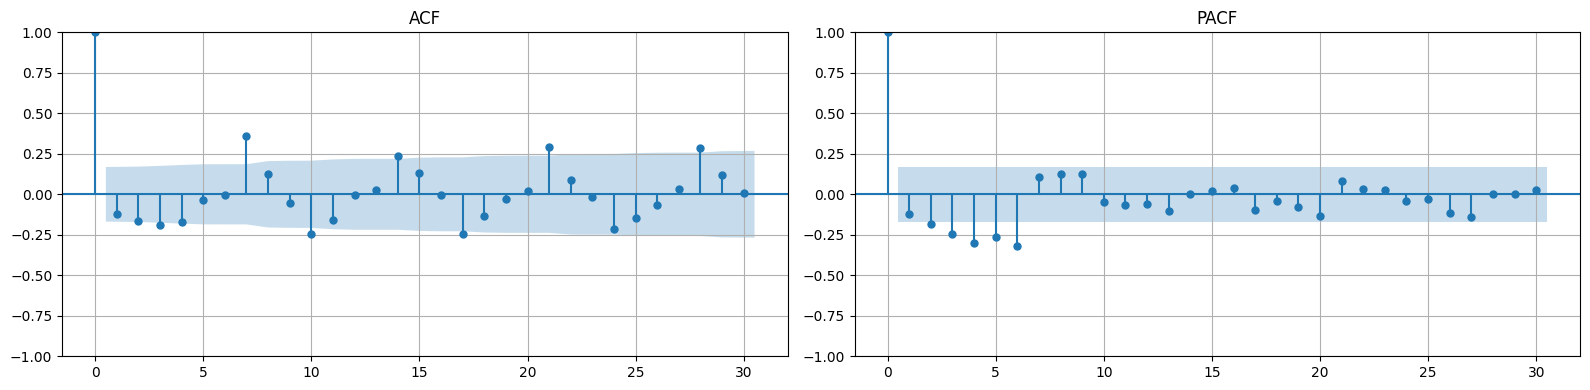

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(df_daily['diff'].dropna(), lags=30, ax=axes[0])
axes[0].set_title("ACF")
axes[0].grid(True)


plot_pacf(df_daily['diff'].dropna(), lags=30, ax=axes[1])
axes[1].set_title("PACF")
axes[1].grid(True)

plt.tight_layout()
plt.show()

- p (looks at past values): (Interprest PACF) How far we should go back to make prediction on current observation: PACF cuts off at none
- d: At which order to get a process stationary, d = 1
- q (looks at past forecast errors): (Interpret ACF), weekly seasonality, suggested to use SARIMA model instead

PACF remove the indirect correlations which ACF shows stacking correlations (due to compounding)

How to Read the ACF Plot
X-axis (lags):

Represents how many time steps (lags) back you're comparing your current value to.

Example: Lag 7 means you're comparing today's ridership to the value 7 days ago.

Y-axis (autocorrelation value):

Shows the correlation coefficient between the time series and its lagged version.

Values range between -1 and 1:

1.0 → Perfect positive correlation.

0.75 → Strong positive correlation.

0.0 → No correlation.

-0.75 → Strong negative correlation.

Summary: in PACF, highest spike at 7, 8, 9 lags with 8 being the slightly highest, lets redo to include 2 months lag

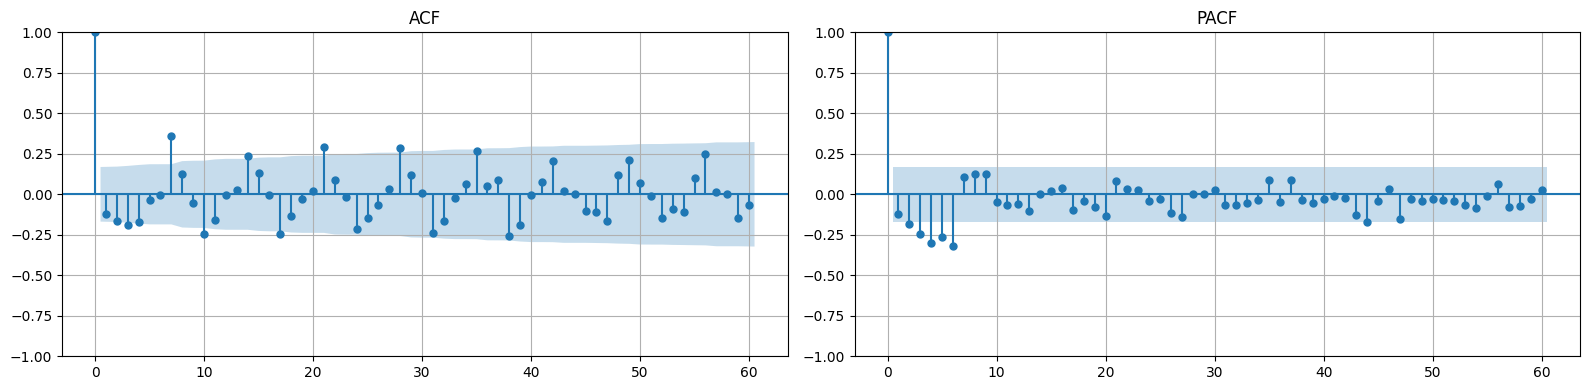

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(df_daily['diff'].dropna(), lags=60, ax=axes[0])
axes[0].set_title("ACF")
axes[0].grid(True)


plot_pacf(df_daily['diff'].dropna(), lags=60, ax=axes[1])
axes[1].set_title("PACF")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Yup definitely lags at 7,8,9 is not seasonal, these are short-term correlations

Let’s say your seasonality period is s = 7 (weekly cycle). Then, you check:

1. PACF → Seasonal AR (P)
Look at lags = 7, 14, 21, ...

- If there's a significant spike at lag 7 in PACF and drops after, that suggests:
- P = 1
- Because the partial autocorrelation is strong only at the first seasonal lag

2. ACF → Seasonal MA (Q)
Look at lags = 7, 14, 21, ...

- If there's a significant spike at lag 7 in ACF and then decays, that suggests:
- Q = 1
- Because the autocorrelation remains high at that periodic lag

🧠 Your case:
- ACF: Strong spike at lag 7, 14, 21 → implies Q = 1
- PACF: Visible spike at lag 7 only, weak after → implies P = 1

Even though spikes appear at 14, 21 too, they're weaker → no need for P=2 or Q=2 unless the model performs poorly.

So our choosen metrics:

- p: 0
- q: 0
- d: 1
- P: 1
- Q: 1
- D: 1
- s: 7 (weekly seasonal)

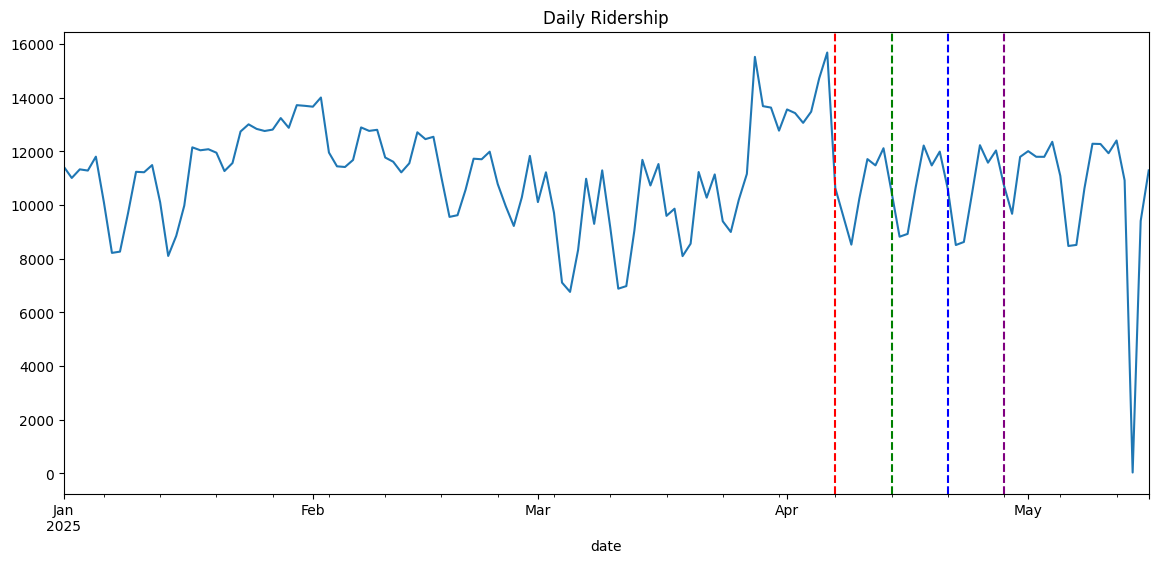

In [16]:
#lets plot
df_daily['ridership'].plot(figsize=(14,6), title="Daily Ridership")
plt.axvline('2025-4-7', color='red',linestyle='--')
plt.axvline('2025-4-14', color='green',linestyle='--')
plt.axvline('2025-4-21', color='blue',linestyle='--')
plt.axvline('2025-4-28', color='purple',linestyle='--')

# Hold up there is data error

In [17]:
df_daily.sort_values(by='date',ascending=False) #whats's happening on 14th May?

,ridership,is_holiday,dayofweek,rolling_mean,rolling_std,diff
date,,,,,,
2025-05-16,11292,False,4,9752.142857,4407.256230,1884.0
2025-05-15,9408,False,3,9894.000000,4480.453586,9378.0
2025-05-14,30,False,2,10067.000000,4481.939907,-10890.0
2025-05-13,10920,False,1,11279.000000,1409.169022,-1487.0
2025-05-12,12407,True,0,10929.714286,1769.843469,475.0
...,...,...,...,...,...,...
2025-01-05,11804,False,6,NaN,NaN,518.0
2025-01-04,11286,False,5,NaN,NaN,-45.0
2025-01-03,11331,False,4,NaN,NaN,321.0


In [18]:
df_daily['ridership'].sum()

np.int64(1498885)

In [19]:
df_daily.mean()

ridership       11021.213235
is_holiday          0.044118
dayofweek           3.000000
rolling_mean    11067.287912
rolling_std      1368.722970
diff               -1.051852
dtype: float64

In [20]:
print(1487593/135)

11019.207407407408


In [21]:
df_daily.sort_values(by='ridership') #Might be data error as it is too far from the second lowest daily total ridership

,ridership,is_holiday,dayofweek,rolling_mean,rolling_std,diff
date,,,,,,
2025-05-14,30,False,2,10067.000000,4481.939907,-10890.0
2025-03-05,6763,False,2,9577.000000,1941.235517,-347.0
2025-03-11,6883,False,1,8959.571429,1790.010974,-2288.0
2025-03-12,6979,False,2,8990.428571,1747.183816,96.0
2025-03-04,7110,False,1,9928.142857,1525.090317,-2602.0
...,...,...,...,...,...,...
2025-01-30,13724,True,3,13038.428571,342.875029,844.0
2025-02-02,14009,False,6,13433.571429,459.760031,342.0
2025-04-05,14724,False,5,13523.857143,610.837247,1244.0


In [22]:
# #plot moving average

# df_daily_non_holiday['rolling_mean'] = df_daily_non_holiday['diff'].dropna().rolling(window=7).mean()
# df_daily_non_holiday['rolling_std'] = df_daily_non_holiday['diff'].dropna().rolling(window=7).std()

# plt.figure(figsize=(12,6))
# plt.plot(df_daily_non_holiday['diff'].dropna(),label='Original')
# plt.plot(df_daily_non_holiday['rolling_mean'], label='7-day rolling mean')
# plt.plot(df_daily_non_holiday['rolling_std'],label='7-day rolling std')
# plt.legend()
# plt.show()

Lets impute the value for 14th May

| Method                | What it does                                           | Good for                                           |
| --------------------- | ------------------------------------------------------ | -------------------------------------------------- |
| Surrounding average   | Takes a few days before and after the anomaly          | One-off imputation                                 |
| 7-day rolling average | Mean of the last 7 days (by default, backward-looking) | Smoothing, detecting trends, imputing missing data |


In [23]:
import numpy as np
df_daily_smoothed = df_daily.copy()
df_daily_smoothed['ridership'] = df_daily_smoothed['ridership'].replace(30,np.nan)

- 7-day rolling average: This typically means the mean of the previous 7 days (not centered, unless you explicitly choose centered)
- This is good for short-term smoothing and seasonality handling.

In [24]:
df_daily_smoothed['ridership'] = df_daily_smoothed['ridership'].fillna(df_daily_smoothed['ridership'].rolling(window=7, min_periods=1).mean())


In [25]:
df_daily_smoothed.sort_values(by='date', ascending=False)

,ridership,is_holiday,dayofweek,rolling_mean,rolling_std,diff
date,,,,,,
2025-05-16,11292.000000,False,4,9752.142857,4407.256230,1884.0
2025-05-15,9408.000000,False,3,9894.000000,4480.453586,9378.0
2025-05-14,11739.833333,False,2,10067.000000,4481.939907,-10890.0
2025-05-13,10920.000000,False,1,11279.000000,1409.169022,-1487.0
2025-05-12,12407.000000,True,0,10929.714286,1769.843469,475.0
...,...,...,...,...,...,...
2025-01-05,11804.000000,False,6,NaN,NaN,518.0
2025-01-04,11286.000000,False,5,NaN,NaN,-45.0
2025-01-03,11331.000000,False,4,NaN,NaN,321.0


# Let's fit in the model!

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [27]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(0,1,0),
                seasonal_order=(1,1,1,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results = model.fit()

print("AIC: ", results.aic)
print("BIC: ", results.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  2012.0759822630757
BIC:  2020.4384574914218


In [28]:
model = SARIMAX(df_daily['ridership'],
                order=(0,1,0),
                seasonal_order=(1,1,1,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results2 = model.fit()

print("AIC: ", results2.aic)
print("BIC: ", results2.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  2119.7231467726083
BIC:  2128.0856220009546


In [29]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(1,1,1),
                seasonal_order=(1,1,1,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results3 = model.fit()

print("AIC: ", results3.aic)
print("BIC: ", results3.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  1992.9928115232433
BIC:  2006.888428988801


In [30]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(0,1,1),
                seasonal_order=(1,1,1,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results4 = model.fit()

print("AIC: ", results4.aic)
print("BIC: ", results4.bic)


c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  1992.8199505228429
BIC:  2003.936444495289


In [31]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(1,1,0),
                seasonal_order=(1,1,1,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results5 = model.fit()

print("AIC: ", results5.aic)
print("BIC: ", results5.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  2011.1751593029865
BIC:  2022.3251262741146


In [32]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(0,1,1),
                seasonal_order=(2,1,2,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results6 = model.fit()

print("AIC: ", results6.aic)
print("BIC: ", results6.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  1875.537739856417
BIC:  1891.8487330841874


In [33]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(0,1,1),
                seasonal_order=(2,1,1,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results7 = model.fit()

print("AIC: ", results7.aic)
print("BIC: ", results7.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  1909.201312712556
BIC:  1922.8823049545285


In [34]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(0,1,1),
                seasonal_order=(1,1,2,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results8 = model.fit()

print("AIC: ", results8.aic)
print("BIC: ", results8.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  1875.892125904767
BIC:  1889.4846202612425


Results8 is the lowest: 
- order=(0,1,1),
- seasonal_order=(1,1,2,7)

| Metric  | Value   | What It Means                                                                              |
| ------- | ------- | ------------------------------------------------------------------------------------------ |
| **AIC** | 1859.9169868452589 | Akaike Information Criterion — penalizes complexity but favors good fit. Lower is better.  |
| **BIC** | 1873.4646378518205 | Bayesian Information Criterion — more strict against complexity than AIC. Lower is better. |


In [35]:
model_fit = results8

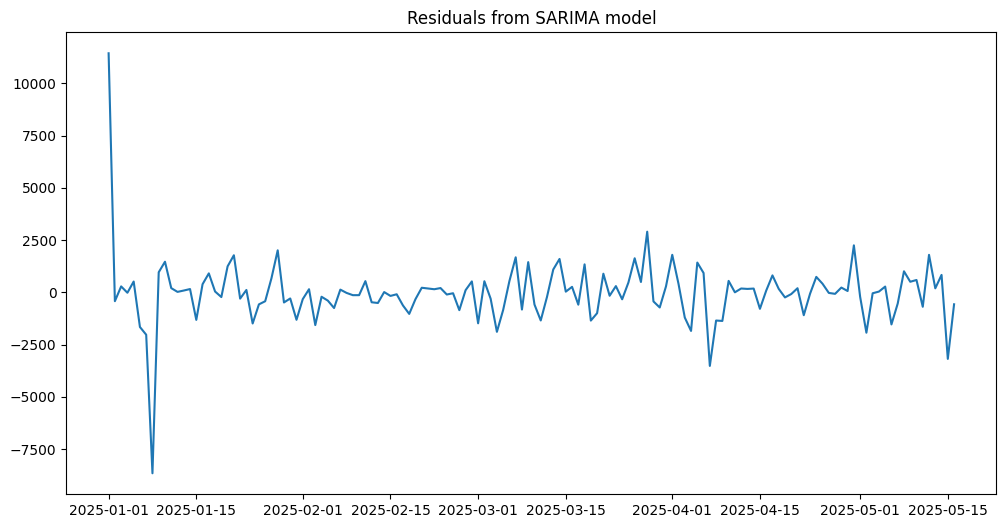

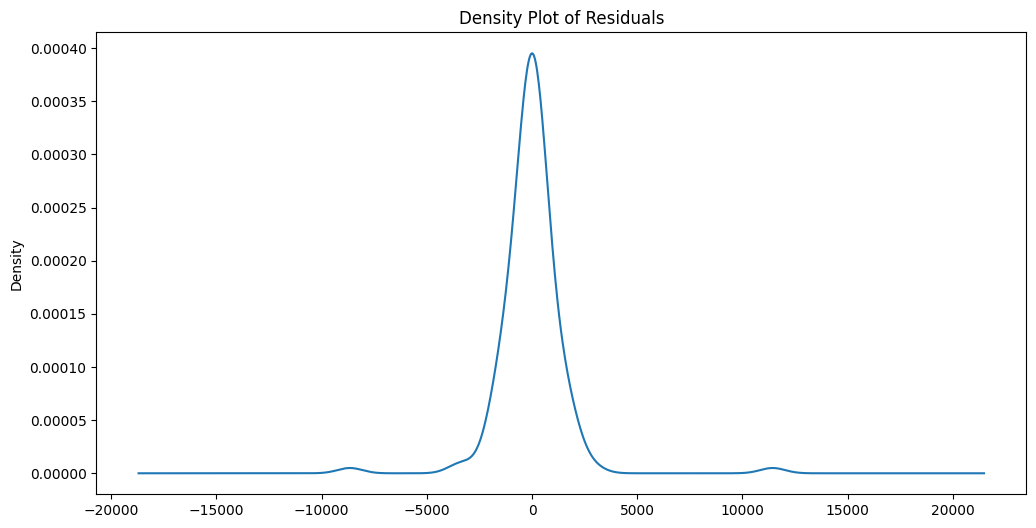

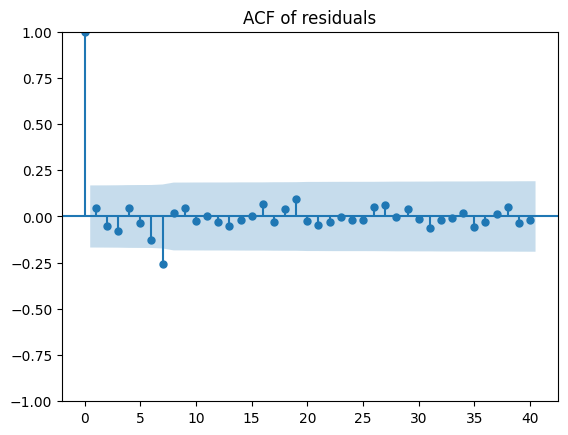

      lb_stat  lb_pvalue
10  14.381397   0.156295
20  17.589882   0.614405


In [36]:
import statsmodels.api as sm
#1. plot residuals
residuals = model_fit.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('Residuals from SARIMA model')
plt.show()

#2. plot residuals density
plt.figure(figsize=(12,6))
residuals.plot(kind='kde')
plt.title("Density Plot of Residuals")
plt.show()

#3. ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals,lags=40)
plt.title('ACF of residuals')
plt.show()

#4. Ljung-Box test to check for autocorrelation in residuals
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10,20], return_df=True)
print(lb_test)

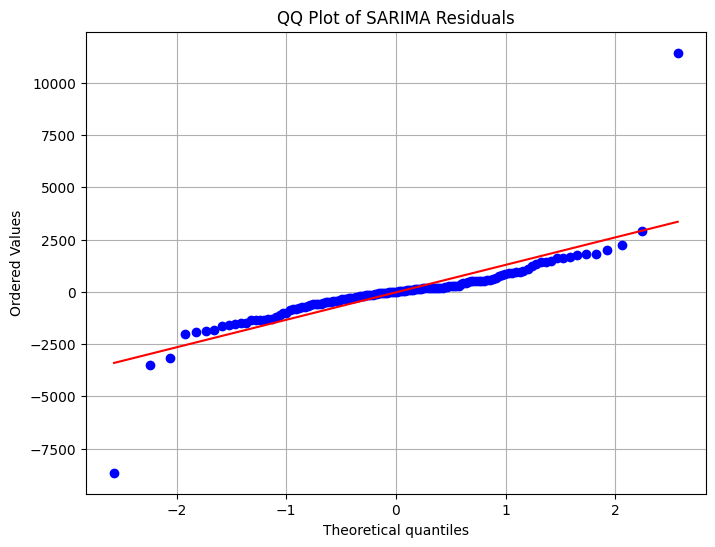

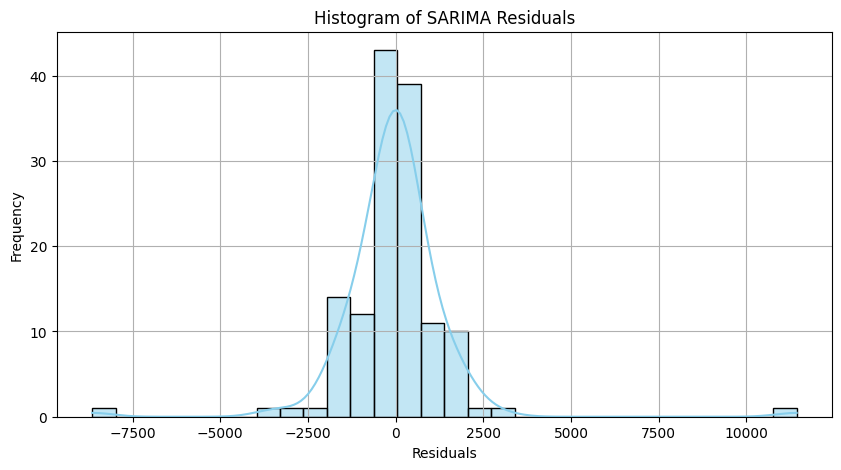

In [37]:
import scipy.stats as stats
import seaborn as sns

residuals = model_fit.resid

#QQ plot
plt.figure(figsize=(8,6))
stats.probplot(residuals,dist="norm", plot=plt)
plt.title("QQ Plot of SARIMA Residuals")
plt.grid()
plt.show()

#Histogram
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.title("Histogram of SARIMA Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid()
plt.show()

How to interpret the QQ plot:
- If the points lie along the 45° line, the residuals are approximately normally distributed.
- Systematic deviations (like an S-curve or heavy tails) indicate the residuals deviate from normality:
- Heavy tails → outliers
- Curved shape → skewness
- Clustering → misspecification or non-normality

How to interpret Histogram:
- A symmetric, bell-shaped curve suggests residuals are roughly normally distributed.
- If it’s skewed, has multiple peaks, or long tails, that may indicate:
- Non-normality
- Model misspecification
- Outliers
- Unaccounted seasonality or trend

In [38]:
model_fit = results8

In [39]:
print(model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:                              ridership   No. Observations:                  136
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 7)   Log Likelihood                -932.946
Date:                                Sat, 17 May 2025   AIC                           1875.892
Time:                                        23:05:21   BIC                           1889.485
Sample:                                    01-01-2025   HQIC                          1881.407
                                         - 05-16-2025                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2892      0.095     -3.054      0.002      -0.475      -0.104
ar.

Interpretation of Ljung-Box "Prob(Q)" in model diagnostics:
- If p-value > 0.05 → Fail to reject the null hypothesis
- This means no significant autocorrelation in residuals — which is good. Your model has likely captured most of the structure in the data, and the residuals resemble white noise.


- If p-value ≤ 0.05 → Reject the null hypothesis
- This suggests autocorrelation is still present in the residuals — a sign that your model may be misspecified or underfitting.

In [40]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(0,1,1),
                seasonal_order=(0,1,1,7),  # Removed ar.S.L7 and ma.S.L14
                enforce_invertibility=False,
                enforce_stationarity=False)

results9 = model.fit()

print("AIC: ", results9.aic)
print("BIC: ", results9.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  1991.517689440673
BIC:  1999.8550599200075


In [41]:
model_fit1 = results9
print(model_fit1.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         ridership   No. Observations:                  136
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                -992.759
Date:                           Sat, 17 May 2025   AIC                           1991.518
Time:                                   23:05:22   BIC                           1999.855
Sample:                               01-01-2025   HQIC                          1994.903
                                    - 05-16-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2805      0.084     -3.352      0.001      -0.444      -0.117
ma.S.L7       -0.8529      0.050    -17.180

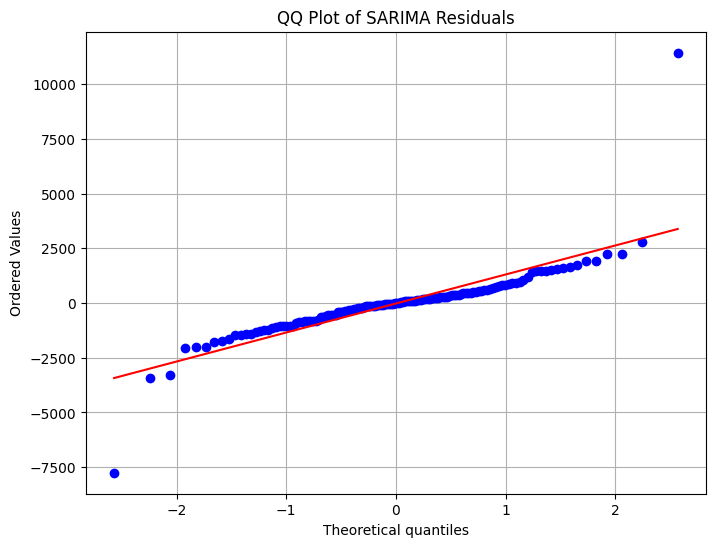

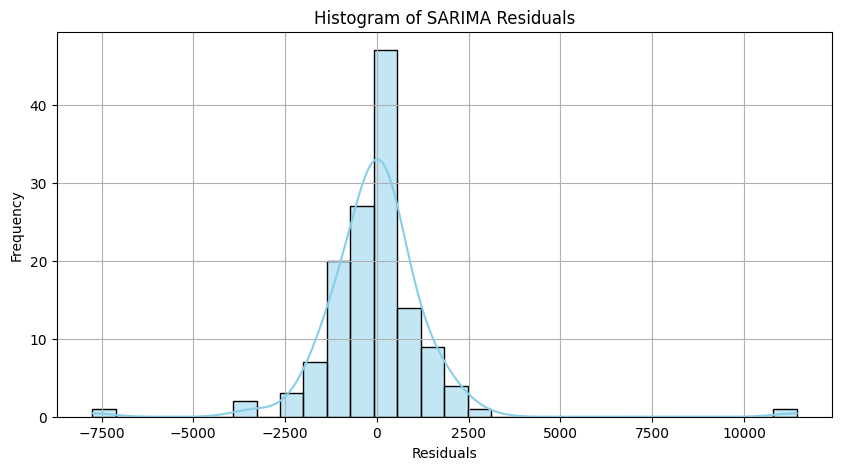

In [42]:
import scipy.stats as stats
import seaborn as sns

residuals = model_fit1.resid

#QQ plot
plt.figure(figsize=(8,6))
stats.probplot(residuals,dist="norm", plot=plt)
plt.title("QQ Plot of SARIMA Residuals")
plt.grid()
plt.show()

#Histogram
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.title("Histogram of SARIMA Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [78]:
model_fit2 = results6
print(model_fit2.summary())

                                       SARIMAX Results                                        
Dep. Variable:                              ridership   No. Observations:                  136
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 7)   Log Likelihood                -931.769
Date:                                Sun, 18 May 2025   AIC                           1875.538
Time:                                        00:03:31   BIC                           1891.849
Sample:                                    01-01-2025   HQIC                          1882.156
                                         - 05-16-2025                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2989      0.093     -3.225      0.001      -0.481      -0.117
ar.

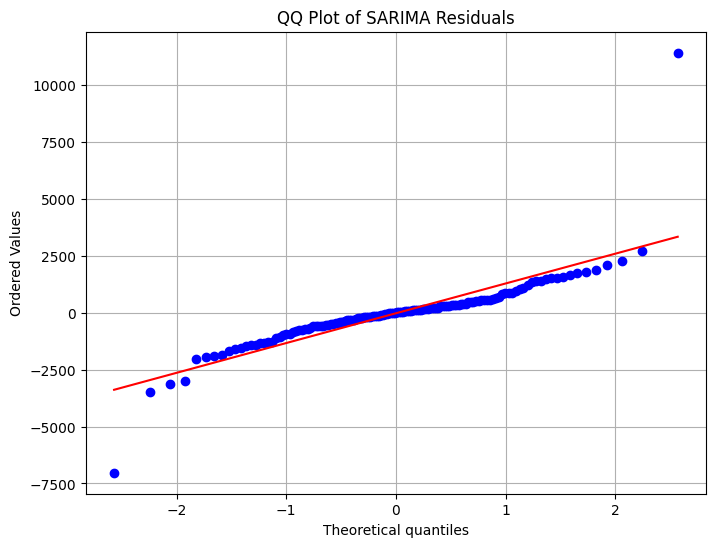

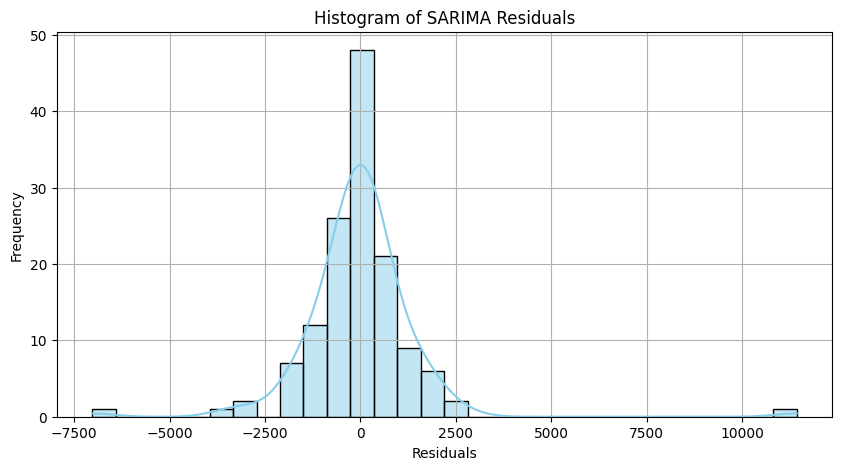

In [44]:
import scipy.stats as stats
import seaborn as sns

residuals = model_fit2.resid

#QQ plot
plt.figure(figsize=(8,6))
stats.probplot(residuals,dist="norm", plot=plt)
plt.title("QQ Plot of SARIMA Residuals")
plt.grid()
plt.show()

#Histogram
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.title("Histogram of SARIMA Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid()
plt.show()

| Model | Description                         | AIC          |
| ----- | ----------------------------------- | ------------ |
| model_fit     | SARIMAX(0,1,1)x(1,1,\[1,2],7)       | 1859.9✅  |
| model_fit1     | SARIMAX(0,1,1)x(0,1,1,7)            | \~1975       |
| **model_fit2** | **SARIMAX(0,1,1)x(2,1,\[1,2],7)** ✅ | **1859.9** ✅ |


# Lets proceed with forecasting on validation dataset

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 1029.85


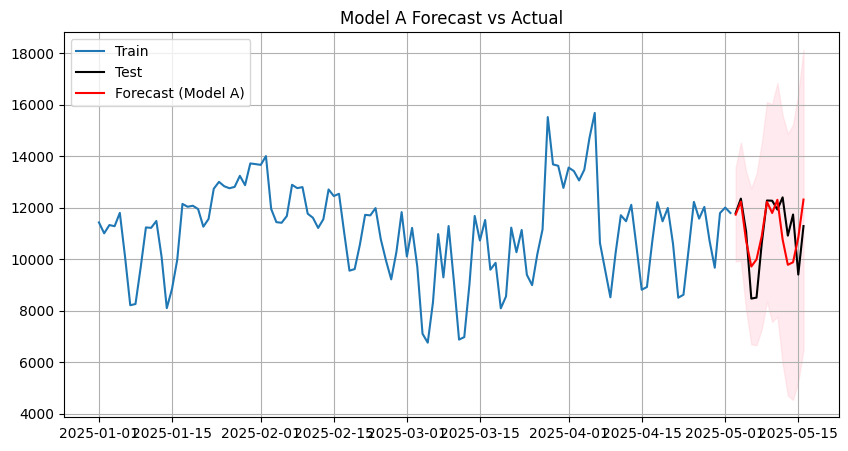

In [45]:
from sklearn.metrics import mean_squared_error

# 1. load data
df_daily_smoothed = df_daily_smoothed.sort_values(by='date', ascending=True)
ts = df_daily_smoothed['ridership']

# 2. Train-test split
train = ts.iloc[:-14] #all data excluding last 14 days
test = ts.iloc[-14:] #testing on the last 14 days

# 3. Fit SARIMAX SARIMAX(0,1,1)x(1,1,[1,2],7)
model_fit = SARIMAX(train,
                    order=(0,1,1),
                    seasonal_order=(1,1,[1,2],7),
                    enforce_stationarity=False,
                    enforce_invertibility=False)

result_a = model_fit.fit()

# 4. Forecast
forecast_a = result_a.get_forecast(steps=len(test))
pred_a = forecast_a.predicted_mean
conf_int = forecast_a.conf_int()

# 5. RMSE
rmse_a = np.sqrt(mean_squared_error(test,pred_a))
print(f'RMSE: {rmse_a:.2f}')

# 6. Optional: Plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='black')
plt.plot(test.index, pred_a, label='Forecast (Model A)', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Model A Forecast vs Actual')
plt.legend()
plt.grid()
plt.show()




c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 1055.61


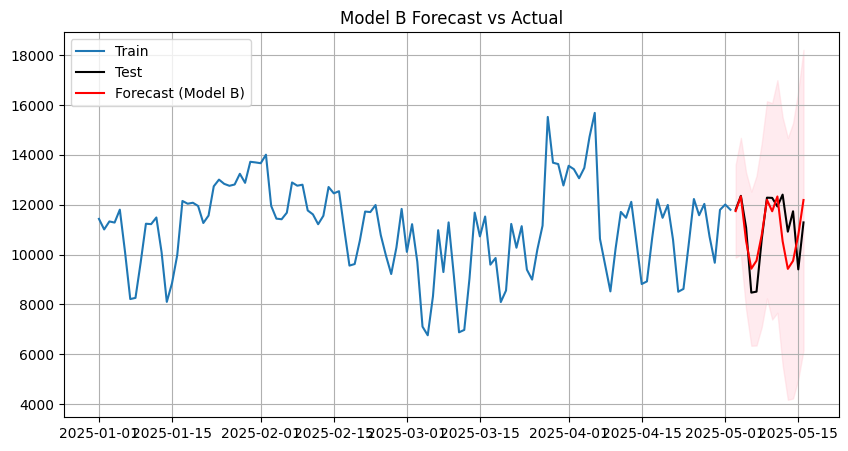

In [46]:
from sklearn.metrics import mean_squared_error

# 1. load data
df_daily_smoothed = df_daily_smoothed.sort_values(by='date', ascending=True)
ts = df_daily_smoothed['ridership']

# 2. Train-test split
train = ts.iloc[:-14] #all data excluding last 14 days
test = ts.iloc[-14:] #testing on the last 14 days

# 3. Fit SARIMAX SARIMAX(0,1,1)x(1,1,1,7)
model_fit1 = SARIMAX(train,
                    order=(0,1,1),
                    seasonal_order=(0,1,1,7),
                    enforce_stationarity=False,
                    enforce_invertibility=False)

result_b = model_fit1.fit()

# 4. Forecast
forecast_b = result_b.get_forecast(steps=len(test))
pred_b = forecast_b.predicted_mean
conf_int = forecast_b.conf_int()

# 5. RMSE
rmse_b = np.sqrt(mean_squared_error(test,pred_b))
print(f'RMSE: {rmse_b:.2f}')

# 6. Optional: Plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='black')
plt.plot(test.index, pred_b, label='Forecast (Model B)', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Model B Forecast vs Actual')
plt.legend()
plt.grid()
plt.show()




c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 1001.18


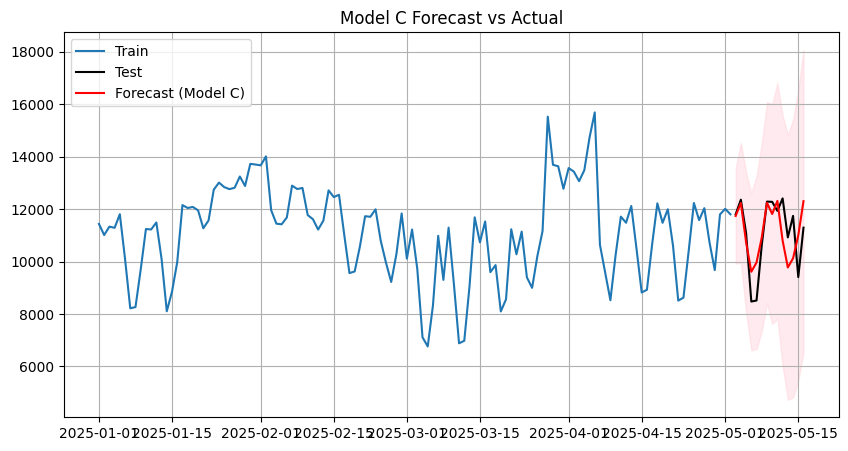

In [66]:
from sklearn.metrics import mean_squared_error

# 1. load data
df_daily_smoothed = df_daily_smoothed.sort_values(by='date', ascending=True)
ts = df_daily_smoothed['ridership']

# 2. Train-test split
train = ts.iloc[:-14] #all data excluding last 14 days
test = ts.iloc[-14:] #testing on the last 14 days

# 3. Fit SARIMAX SARIMAX(0,1,1)x(1,1,[1,2],7)
model_fit2 = SARIMAX(train,
                    order=(0,1,1),
                    seasonal_order=(2,1,[1,2],7),
                    enforce_stationarity=False,
                    enforce_invertibility=False)

result_c = model_fit2.fit()

# 4. Forecast
forecast_c = result_c.get_forecast(steps=len(test))
pred_c = forecast_c.predicted_mean
conf_int = forecast_c.conf_int()

# 5. RMSE
rmse_c = np.sqrt(mean_squared_error(test,pred_c))
print(f'RMSE: {rmse_c:.2f}')

# 6. Optional: Plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='black')
plt.plot(test.index, pred_c, label='Forecast (Model C)', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Model C Forecast vs Actual')
plt.legend()
plt.grid()
plt.show()


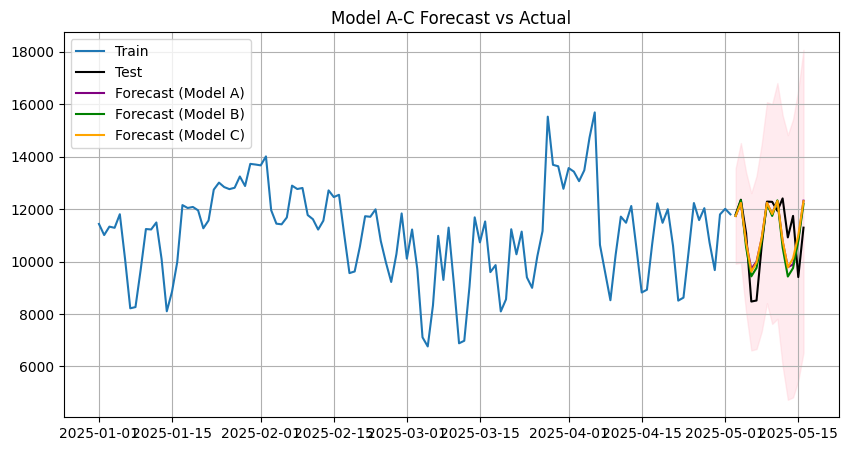

In [67]:
# 7. Optional: Plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='black')
plt.plot(test.index, pred_a, label='Forecast (Model A)', color='purple')
plt.plot(test.index, pred_b, label='Forecast (Model B)', color='green')
plt.plot(test.index, pred_c, label='Forecast (Model C)', color='orange')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Model A-C Forecast vs Actual')
plt.legend()
plt.grid()
plt.show()

# Imputation on holidays to smooth the variance

In [68]:
df_daily_smoothed

,ridership,is_holiday,dayofweek,rolling_mean,rolling_std,diff,ridership_smoothed,rolling_mean_7
date,,,,,,,,
2025-01-01,11434.000000,False,2,NaN,NaN,NaN,11434.000000,11434.000000
2025-01-02,11010.000000,False,3,NaN,NaN,-424.0,11010.000000,11222.000000
2025-01-03,11331.000000,False,4,NaN,NaN,321.0,11331.000000,11258.333333
2025-01-04,11286.000000,False,5,NaN,NaN,-45.0,11286.000000,11265.250000
2025-01-05,11804.000000,False,6,NaN,NaN,518.0,11804.000000,11373.000000
...,...,...,...,...,...,...,...,...
2025-05-12,12407.000000,True,0,10929.714286,1769.843469,475.0,10929.714286,10929.714286
2025-05-13,10920.000000,False,1,11279.000000,1409.169022,-1487.0,10920.000000,11279.000000
2025-05-14,11739.833333,False,2,10067.000000,4481.939907,-10890.0,11739.833333,11739.833333


In [69]:
df_daily_smoothed['rolling_mean_7'] = df_daily_smoothed['ridership'].rolling(window=7, min_periods=1).mean()

In [70]:
df_daily_smoothed['ridership_smoothed'] = df_daily_smoothed.apply(lambda x: x['ridership'] if x['is_holiday']==False else x['rolling_mean_7'],axis=1 )

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 1000.20


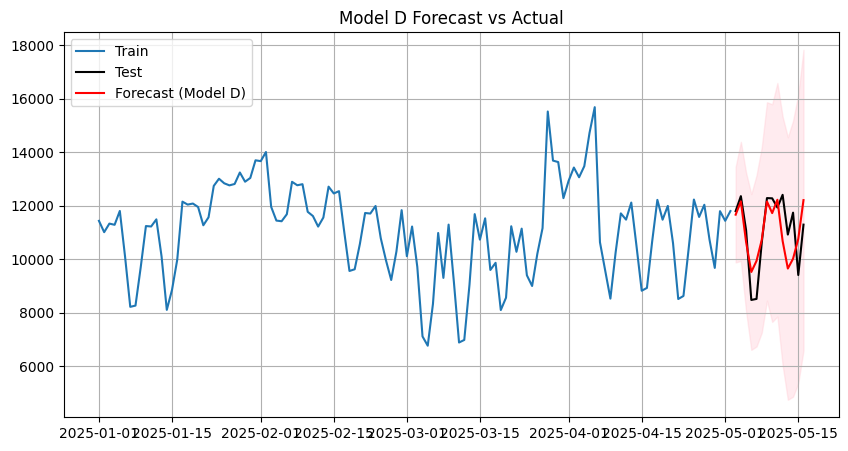

In [84]:
from sklearn.metrics import mean_squared_error

# 1. load data
df_daily_smoothed = df_daily_smoothed.sort_values(by='date', ascending=True)
ts1 = df_daily_smoothed['ridership_smoothed']
ts = df_daily_smoothed['ridership']


# 2. Train-test split
train = ts1.iloc[:-14] #all data excluding last 14 days
test = ts.iloc[-14:] #testing on the last 14 days

# 3. Fit SARIMAX SARIMAX(0,1,1)x(1,1,[1,2],7)
model_fit3 = SARIMAX(train,
                    order=(0,1,1),
                    seasonal_order=(2,1,[1,2],7),
                    enforce_stationarity=False,
                    enforce_invertibility=False)

result_d = model_fit3.fit()

# 4. Forecast
forecast_d = result_d.get_forecast(steps=len(test))
pred_d = forecast_d.predicted_mean
conf_int = forecast_d.conf_int()

# 5. RMSE
rmse_d = np.sqrt(mean_squared_error(test,pred_d))
print(f'RMSE: {rmse_d:.2f}')

# 6. Optional: Plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='black')
plt.plot(test.index, pred_d, label='Forecast (Model D)', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Model D Forecast vs Actual')
plt.legend()
plt.grid()
plt.show()


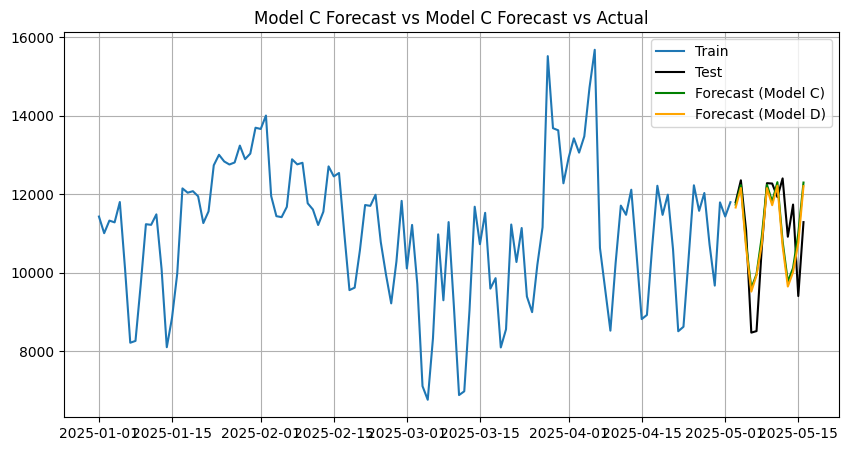

In [85]:
# 7. Optional: Plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='black')
plt.plot(test.index, pred_c, label='Forecast (Model C)', color='green')
plt.plot(test.index, pred_d, label='Forecast (Model D)', color='orange')
plt.title('Model C Forecast vs Model C Forecast vs Actual')
plt.legend()
plt.grid()
plt.show()

| Model | Description                         | RMSE         |
| ----- | ----------------------------------- | ------------ |
| model_fit     | SARIMAX(0,1,1)x(1,1,\[1,2],7)       | 1029.85  |
| model_fit1     | SARIMAX(0,1,1)x(0,1,1,7)            | 1055.61       |
| model_fit2 | SARIMAX(0,1,1)x(2,1,\[1,2],7) | 1001.18  |
| **model_fit3**     | **SARIMAX(0,1,1)x(0,1,1,7)  and 7-day-rolling on holidays**         | **1000.20**       |


In [86]:
# let's zoom in to the predicted result on test data
pred_d.index = test.index

comparison = pd.DataFrame({
    'Actual': test,
    'Predicted': pred_d
})

print(comparison)

                  Actual     Predicted
date                                  
2025-05-03  11798.000000  11664.790344
2025-05-04  12358.000000  12162.375733
2025-05-05  11086.000000  10642.274069
2025-05-06   8475.000000   9521.147027
2025-05-07   8514.000000   9936.390920
2025-05-08  10619.000000  10717.825319
2025-05-09  12285.000000  12158.608118
2025-05-10  12276.000000  11723.562318
2025-05-11  11932.000000  12222.128479
2025-05-12  12407.000000  10682.732067
2025-05-13  10920.000000   9650.190694
2025-05-14  11739.833333  10016.859662
2025-05-15   9408.000000  10758.331062
2025-05-16  11292.000000  12209.786005


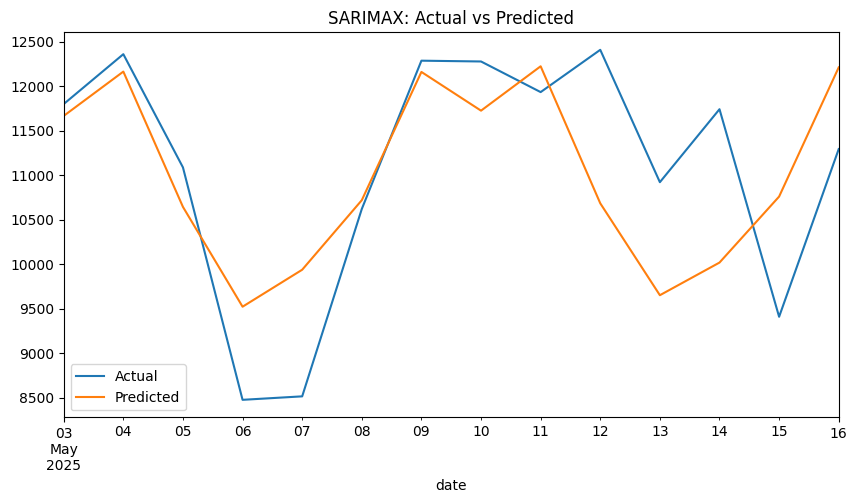

In [87]:
comparison.plot(figsize=(10,5))
plt.title("SARIMAX: Actual vs Predicted")
plt.show()

# Future work: Let's include SARIMAX with exog to learn the impact of holidays rather than smoothing them out manually